# Datset: Pairwise approach

Get tracksters from a certain neighbourhood.

Neighbourhood:
- get links from ticlNtuplizer/graph
    - figure out how these links are formed

Graph:
- linked_inners
    - nodes linked to the given tracksters within its cone


In [1]:
import uproot
import torch
import random
import numpy as np

from reco.distance import euclidian_distance, get_z_map, apply_map
from reco.matching import find_good_pairs
from reco.dataset import match_trackster_pairs, TracksterPairs
from reco.plotting import plot_tracksters
from reco.event import get_bary

import matplotlib.pyplot as plt

ds_name = "MultiParticle"

data_root = "data"
raw_dir = f"/Users/ecuba/data/{ds_name}"

# data_root = "/mnt/ceph/users/ecuba/processed"
# raw_dir = f"/mnt/ceph/users/ecuba/{ds_name}"

file_name = f"{raw_dir}/new_ntuples_15163313_1.root"

tracksters = uproot.open({file_name: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_name: "ticlNtuplizer/simtrackstersSC"})
associations = uproot.open({file_name: "ticlNtuplizer/associations"})
graph = uproot.open({file_name: "ticlNtuplizer/graph"})

z_map = get_z_map(data_root)

In [12]:
eid = 0

# prepare distance points
vx = tracksters["vertices_x"].array()[eid]
vy = tracksters["vertices_y"].array()[eid]
vz = tracksters["vertices_z"].array()[eid]
vz = [apply_map(tx, z_map, factor=2) for tx in tracksters["vertices_z"].array()[eid]]
ve = tracksters["vertices_energy"].array()[eid]
re = tracksters["raw_energy"].array()[eid]
clouds = [np.array([vx[tid], vy[tid], vz[tid]]).T for tid in range(len(vx))]

## Candidate pairs

Compile a list of candidate pairs based on the CLUE3D graph and node distance.

Reject all nodes with above a distance threshold.

In [31]:
MAX_DISTANCE = 10       # cm
ENERGY_THRESHOLD = 10   # GeV

candidate_pairs = []
distances = []

# little -> big
inners_list = graph["linked_inners"].array()[eid]
for i, inners in enumerate(inners_list):
    for inner in inners:
        e_pair = (re[i], re[inner])
        if min(e_pair) < ENERGY_THRESHOLD and max(e_pair) > ENERGY_THRESHOLD:
            dst = euclidian_distance(clouds[i], clouds[inner])
            distances.append(dst)
            if dst <= MAX_DISTANCE:
                candidate_pairs.append((i, inner) if re[i] < re[inner] else (inner, i))
            
print("Candidate pairs:", len(candidate_pairs))
c_pairs = set(candidate_pairs)

Candidate pairs: 204


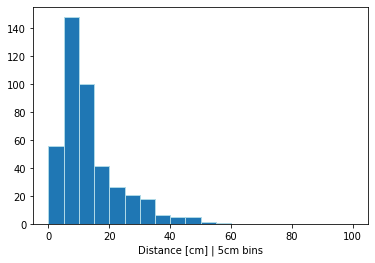

In [32]:
plt.hist(distances, bins=20, edgecolor="lightblue", range=(0, 100))
plt.xlabel("Distance [cm] | 5cm bins")
plt.show()

## Ground truth

This is tricky:
- the ideal situation would be to always connect to the closest trackster of the same particle that is over 10GeV
- we could restrict the candidate pairs to only contain (little, big) combinations

Then two approaches are possible:
- construct the ground truth independently and look at the intersection with the candidate list
- or just evaluate whether two candidates come from the same particle (easier way?)

In [33]:
# ground truth approach
gt_pairs = match_trackster_pairs(
    tracksters,
    simtracksters,
    associations,
    eid,
    energy_threshold=ENERGY_THRESHOLD,
    distance_threshold=MAX_DISTANCE,
    best_only=False, 
    z_map=z_map
)

ab_pairs = set([(a, b) for a, b, _ in gt_pairs])
ba_pairs = set([(b, a) for a, b, _ in gt_pairs])

gt_matches = ab_pairs.union(ba_pairs).intersection(c_pairs)
gt_not_matches = c_pairs - gt_matches

print("Ground truth pairs:", len(gt_pairs), "matches:", len(gt_matches), "non-matches:", len(gt_not_matches))

Ground truth pairs: 41 matches: 41 non-matches: 163


In [34]:
%time _ = match_trackster_pairs(tracksters, simtracksters, associations, eid, energy_threshold=ENERGY_THRESHOLD, distance_threshold=MAX_DISTANCE, best_only=False)

CPU times: user 48.2 ms, sys: 2.89 ms, total: 51 ms
Wall time: 48.8 ms


In [35]:
# good pairs approach
c_matches = find_good_pairs(tracksters, associations, c_pairs, eid, confidence_threshold=0.45)
c_not_matches = c_pairs - c_matches

print("matches:", len(c_matches), "non-matches:", len(c_not_matches))

matches: 44 non-matches: 160


In [36]:
%time _ = find_good_pairs(tracksters, associations, c_pairs, eid, confidence_threshold=0.45)

CPU times: user 20.6 ms, sys: 1.01 ms, total: 21.7 ms
Wall time: 21 ms


In [37]:
# they do agree! (most of the time)
gt_matches.symmetric_difference(c_matches)
# find good pairs is faster so let's stick to it

{(28, 44),
 (32, 44),
 (33, 13),
 (33, 47),
 (33, 55),
 (34, 13),
 (34, 47),
 (34, 49),
 (36, 44),
 (37, 44),
 (57, 44),
 (61, 47),
 (61, 55)}

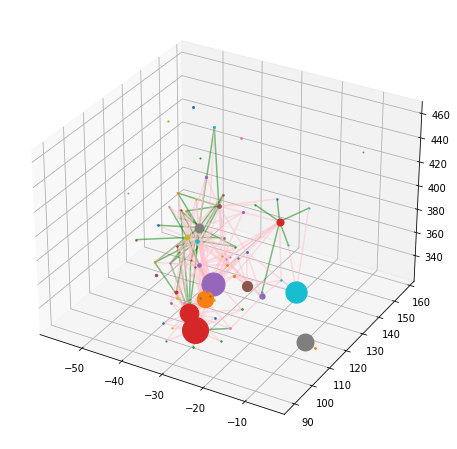

In [38]:
positive = list(c_matches)
negative = list(c_not_matches)

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(111, projection='3d')

bary = get_bary(tracksters, eid)

for i, tx in enumerate(bary):
    ax1.scatter(tx[0], tx[1], tx[2], s=re[i])

def plot_edge(ax, edge, color):
    a, b = edge
    ca = bary[a]
    cb = bary[b]
    x = (ca[0], cb[0])
    y = (ca[1], cb[1])
    z = (ca[2], cb[2])
    ax.plot(x, y, z, c=color, alpha=0.5)

for edge in positive:
    plot_edge(ax1, edge, "green")

for edge in negative:
    plot_edge(ax1, edge, "pink")
plt.show()

## Dataset

In [39]:
ds = TracksterPairs(
    ds_name,
    data_root,
    raw_dir,
    N_FILES=2,
    MAX_DISTANCE=10,
    ENERGY_THRESHOLD=10
)
ds

<TracksterPairs len=70370 max_distance=10 energy_threshold=10>

In [40]:
float(sum(ds.y) / len(ds.y))

0.3636634945869446

## Dummy evaluation

Let's talk baselines on this dataset. How good is a random guess?
How good is connecting to all nodes in a neighbourhood?

In [2]:
from reco.evaluation import pairwise_model_evaluation
from reco.dummy import DummyPleaser, DummyScaler

In [6]:
result = pairwise_model_evaluation(
    tracksters,
    simtracksters,
    associations,
    graph,
    DummyPleaser(),
    DummyScaler(),
    0.5,
    max_distance=30,
    energy_threshold=20,
    max_events=10,
    reco_to_target=False,
    z_map=z_map
)

Event 0:
	clue3d_to_sim:	P: 0.85 R: 0.18 F: 0.21
	target_to_sim:	P: 0.84 R: 0.24 F: 0.28
	reco_to_sim:	P: 0.79 R: 0.36 F: 0.40
Event 1:
	clue3d_to_sim:	P: 0.78 R: 0.09 F: 0.11
	target_to_sim:	P: 0.80 R: 0.25 F: 0.29
	reco_to_sim:	P: 0.67 R: 0.24 F: 0.28
Event 2:
	clue3d_to_sim:	P: 0.93 R: 0.29 F: 0.33
	target_to_sim:	P: 0.93 R: 0.57 F: 0.62
	reco_to_sim:	P: 0.81 R: 0.48 F: 0.52
Event 3:
	clue3d_to_sim:	P: 0.82 R: 0.15 F: 0.18
	target_to_sim:	P: 0.84 R: 0.41 F: 0.46
	reco_to_sim:	P: 0.72 R: 0.32 F: 0.36
Event 4:
	clue3d_to_sim:	P: 0.77 R: 0.12 F: 0.14
	target_to_sim:	P: 0.77 R: 0.22 F: 0.25
	reco_to_sim:	P: 0.77 R: 0.30 F: 0.35
Event 5:
	clue3d_to_sim:	P: 0.86 R: 0.19 F: 0.23
	target_to_sim:	P: 0.87 R: 0.36 F: 0.41
	reco_to_sim:	P: 0.64 R: 0.30 F: 0.34
Event 6:
	clue3d_to_sim:	P: 0.84 R: 0.22 F: 0.26
	target_to_sim:	P: 0.85 R: 0.44 F: 0.48
	reco_to_sim:	P: 0.80 R: 0.45 F: 0.49
Event 7:
	clue3d_to_sim:	P: 0.88 R: 0.31 F: 0.35
	target_to_sim:	P: 0.89 R: 0.54 F: 0.58
	reco_to_sim:	P: 0.78 